In [62]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE
from math import sqrt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, classification_report,roc_curve, auc 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Data Description

#### Loading Dataset

In [2]:
df= pd.read_csv("Fraud.csv")

In [3]:
df.shape

(6362620, 11)

#### Columns

**step**: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount**: amount of the transaction in local currency.

**nameOrig**: customer who started the transaction

**oldbalanceOrg**: initial balance before the transaction

**newbalanceOrig**: new balance after the transaction

**nameDest**: customer who is the recipient of the transaction

**oldbalanceDest**: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest**: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud**: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud**: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### 1. Data Analysis

In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


- **56.7%** of the data is 0 in **newbalanceOrig** and **33%** in **oldbalanceOrg** column.
- There are some Extreme outliers

- Approx **40%** data is 0 in **oldbalanceDest** and **newbalanceDest** column.

##### isFraud

In [9]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

- The dataset is highly imbalanced.

##### isFlaggedFraud

In [10]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

This column seems insignificant. as there are only 16 flagged transaction.

##### step

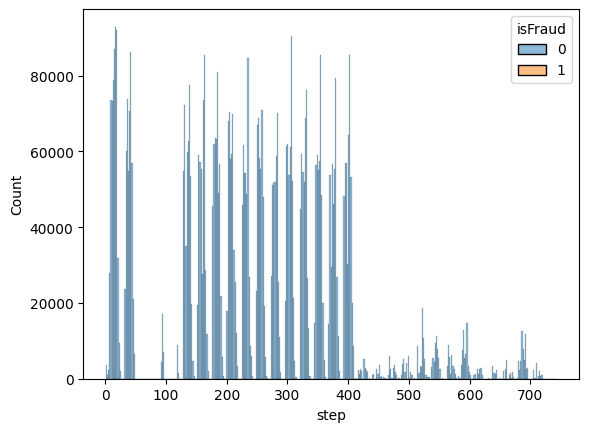

In [11]:
sns.histplot(x='step', data=df,hue='isFraud');

It is difficult to identify fraud transcation time duration, but we notice that
- Most of the values are below 400
- Mean is 243.39725

indicates mean of the transactions lie at **10th day of a month** and most of the transactions are done within **17th day** of a month

##### Type

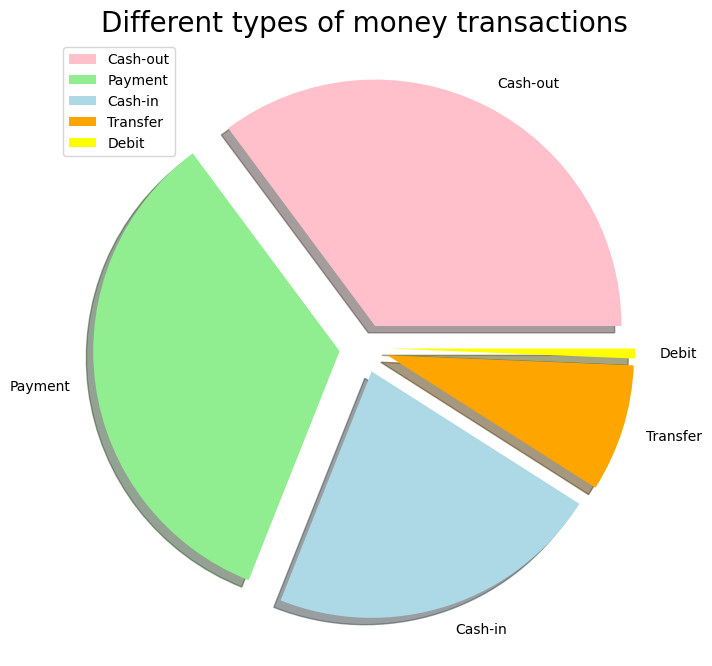

In [12]:
labels = ['Cash-out', 'Payment', 'Cash-in', 'Transfer', 'Debit']
size = [2237500, 2151495, 1399284, 532909, 41432]
colors = ['pink', 'lightgreen', 'lightblue', 'orange', 'yellow']
explode = [0.1, 0.1, 0.1, 0.1, 0.1]

plt.rcParams['figure.figsize'] = (8,8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True)
plt.title('Different types of money transactions', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

- **Cash_out** and **Payment** are the most occuring type of transaction.

##### amount

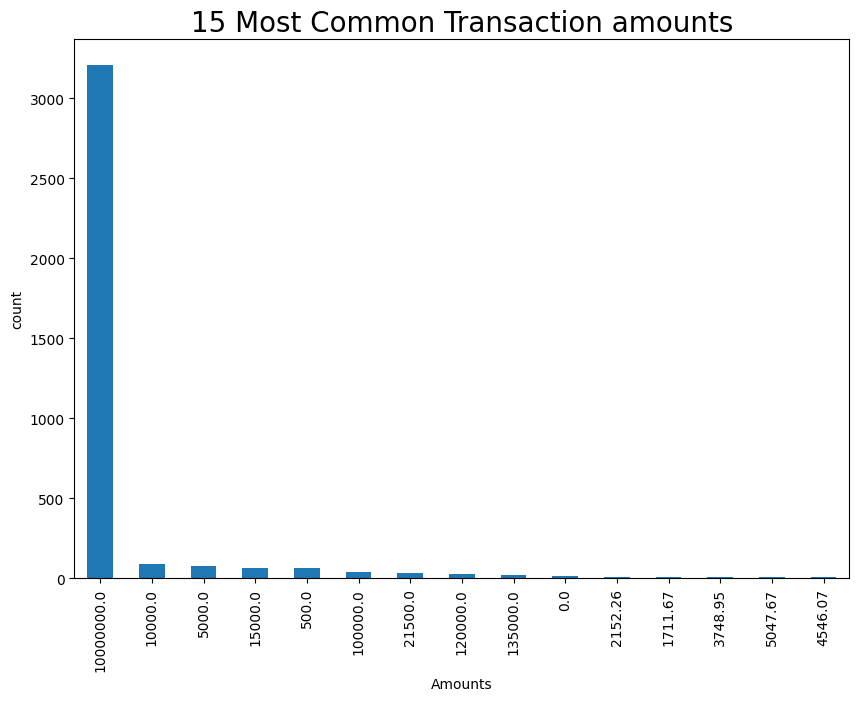

In [13]:
plt.rcParams['figure.figsize'] = (10, 7)

df['amount'].value_counts().head(15).plot.bar()
plt.title('15 Most Common Transaction amounts', fontsize = 20)
plt.xlabel('Amounts')
plt.ylabel('count')
plt.show()

- Most occuring transaction is of amt. 1 crore. This is an extreme value and skewing the dataset.

### Outliers

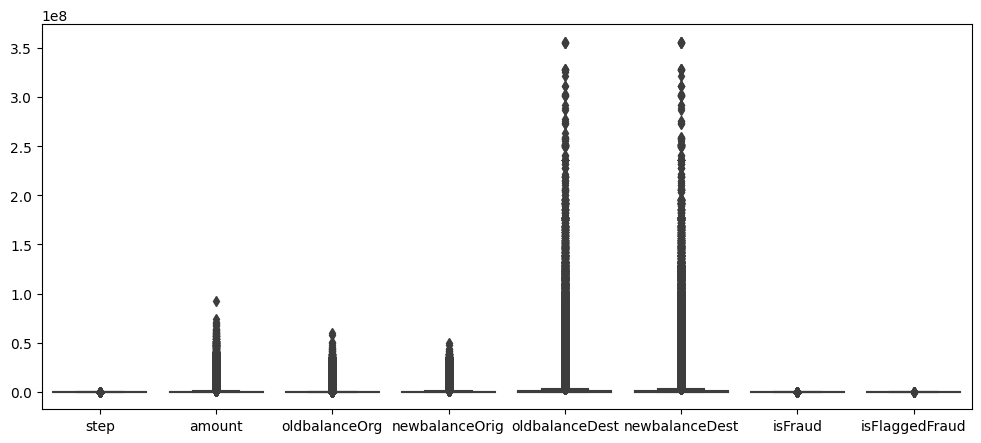

In [14]:
fig = plt.figure(figsize=(12,5))
sns.boxplot(df)
plt.show()

In [15]:
Q1=df['step'].quantile(0.25)
Q3=df['step'].quantile(0.75)
iqr=Q3-Q1
up_limit=Q3+(1.5*iqr)
low_limit=Q1-(1.5*iqr)
print("upper limit :- ",up_limit)
print("upper limit :- ",low_limit)

upper limit :-  603.5
upper limit :-  -112.5


In [16]:
df[df['step']>603].shape

(102688, 11)

More than **100k** values are outliers in step column.
But we can't drop them as there are only few fraudulent transactions and removing outliers is also removing these fraud transactions. 

### Fraud data analysis

In [17]:
fraud_df = df[df['isFraud']==1]

In [18]:
fraud_df['type'].value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

It is clear that fraudent agents only targeted **CASH_OUT** and **TRANSFER** type of trans. becuase **100%** fraud transactions are lie inside these two types.

## Feature Engineering

Q.How much amount has been credited to reciever's account in effect to the transaction?

In [19]:
df["reciever_credited_money_amt"]=df["newbalanceDest"]-df["oldbalanceDest"] 

Q. how much amount has been debited from payer's account in effect to the transaction?

In [20]:
df["payer_debited_amt"]=df["oldbalanceOrg"]-df["newbalanceOrig"]

In [21]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,reciever_credited_money_amt,payer_debited_amt
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0.00,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.00,1864.28
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.00,181.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,-21182.00,181.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.00,11668.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,339682.13,339682.13
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0.00,6311409.28
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,6311409.27,6311409.28
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.00,850002.52


### Label encoding 

In [22]:
df['type']=df['type'].map({'CASH_OUT':0, 'PAYMENT':1,'CASH_IN':2,'TRANSFER':3,'DEBIT':4})

#### Multicollinearity and Correlation Heatmap

- correlation matrix will tell us which features show multicollinearity

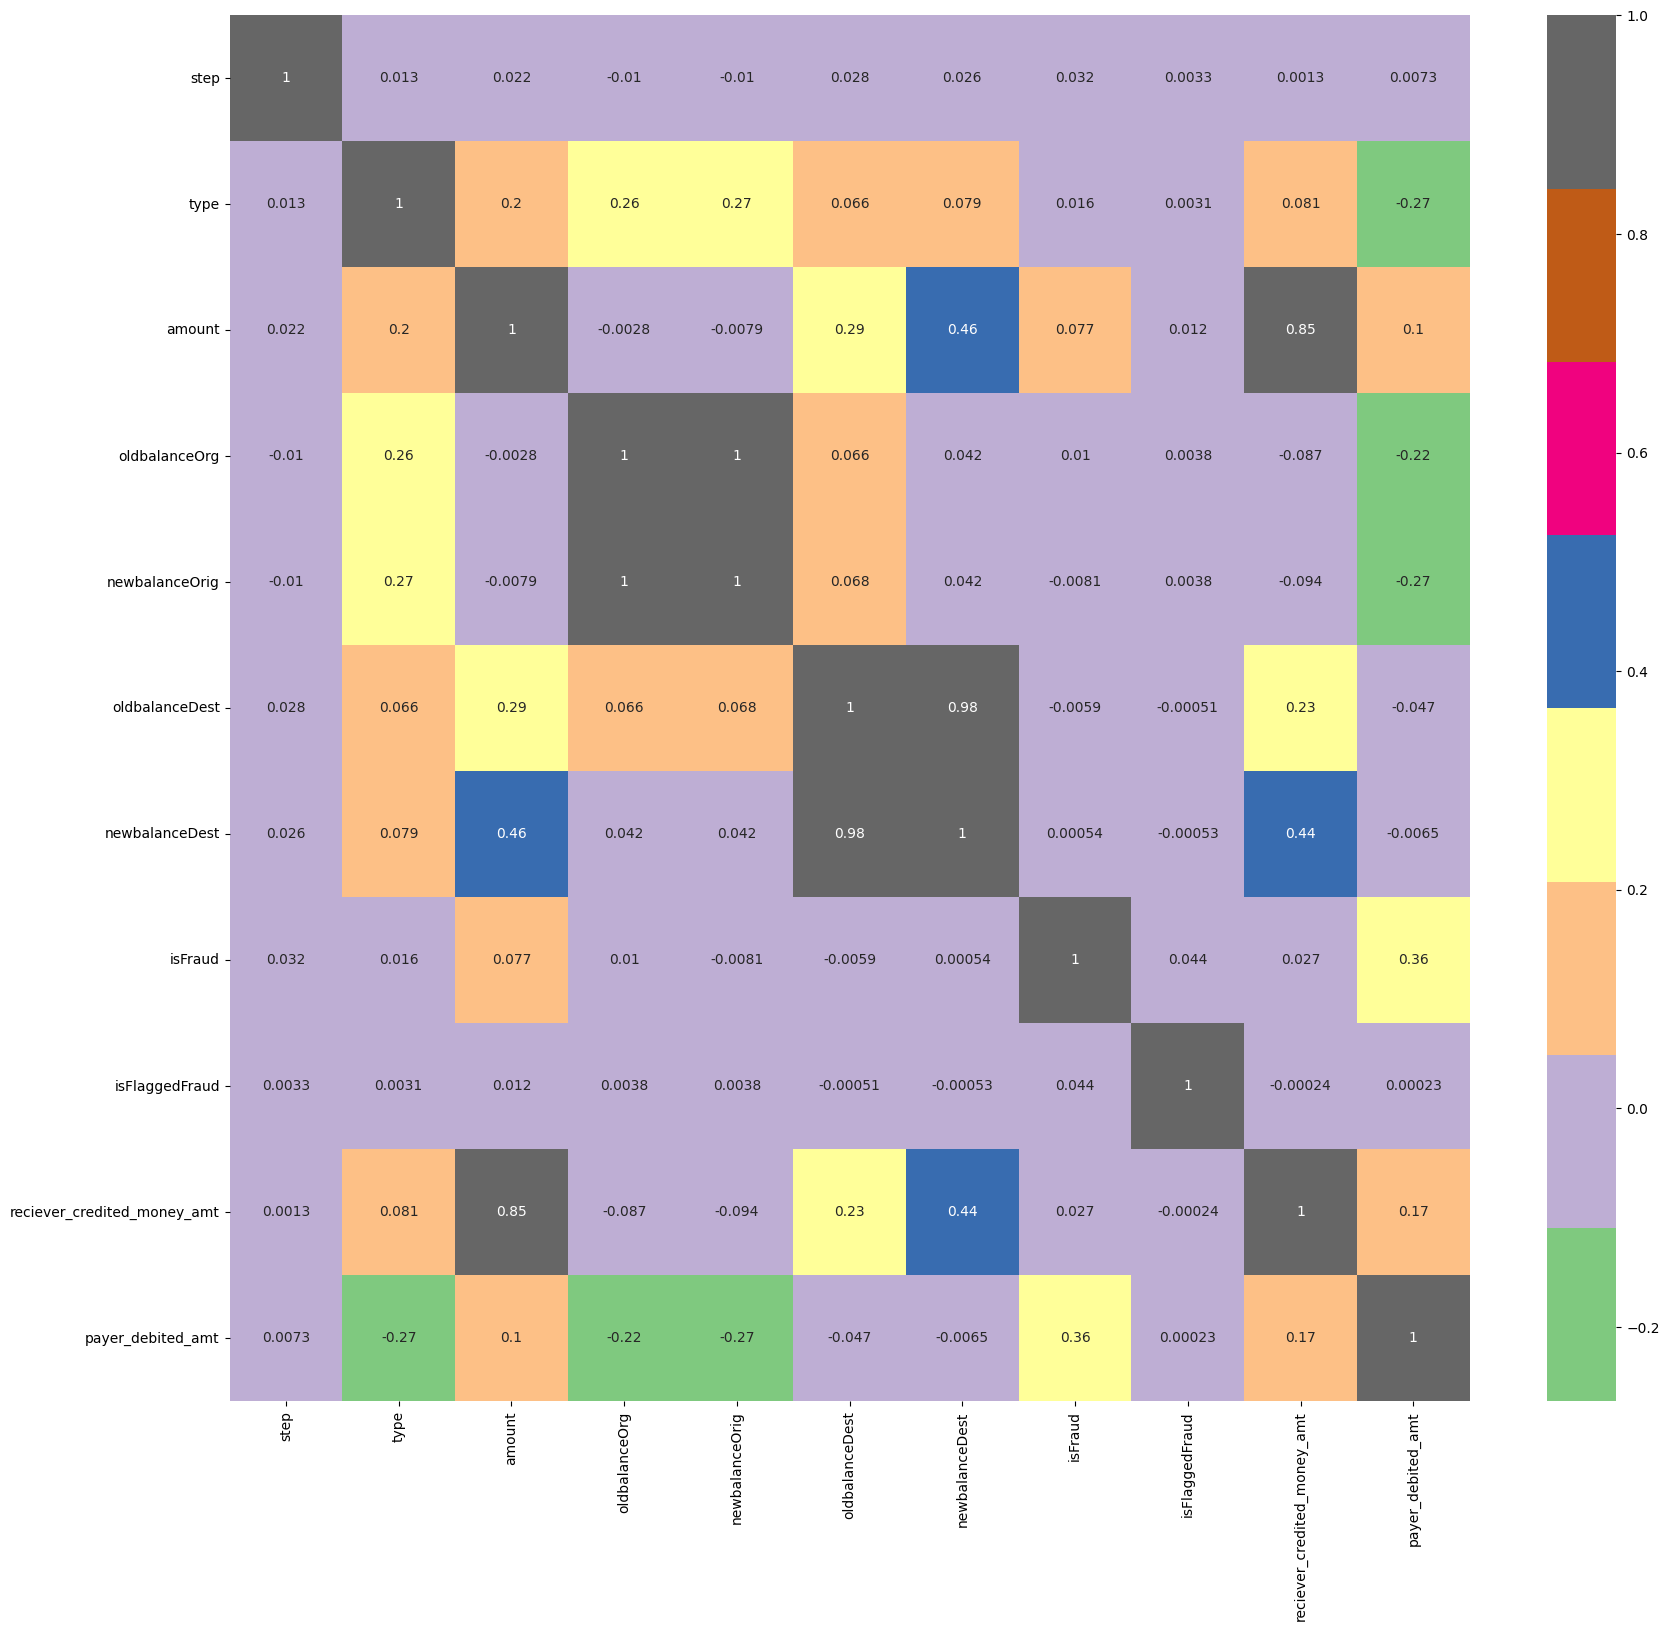

In [23]:
plt.figure(figsize=(20,18))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot = True, cmap="Accent")
plt.show()

In [24]:
# Calculating VIF
sample_df = df.sample(n=100000, random_state=42) 
sample_df = sample_df.select_dtypes(include=[np.number])

In [25]:
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

In [26]:
vif_df = calc_vif(sample_df)
vif_df

,variables,VIF
0,step,1.735789
1,type,2.185555
2,amount,3.992022
3,oldbalanceOrg,inf
4,newbalanceOrig,inf
5,oldbalanceDest,inf
6,newbalanceDest,inf
7,isFraud,1.196050
8,isFlaggedFraud,1.009901
9,reciever_credited_money_amt,inf


We can see that **oldbalanceOrg** and **newbalanceOrig** have too high VIF thus they are highly correlated. Similarly **oldbalanceDest** and **newbalanceDest**. 

#### Dropping Columns

In [27]:
todrop=["nameDest",    # Merchant and Custotomer receipts
        "nameOrig",    
        "oldbalanceOrg",   # correlated
        "newbalanceOrig",
        "newbalanceDest",
        "oldbalanceDest",
        "isFlaggedFraud"   # Not much info 
       ]
df.drop(columns=todrop, inplace=True)

In [28]:
df

,step,type,amount,isFraud,reciever_credited_money_amt,payer_debited_amt
0,1,1,9839.64,0,0.00,9839.64
1,1,1,1864.28,0,0.00,1864.28
2,1,3,181.00,1,0.00,181.00
3,1,0,181.00,1,-21182.00,181.00
4,1,1,11668.14,0,0.00,11668.14
...,...,...,...,...,...,...
6362615,743,0,339682.13,1,339682.13,339682.13
6362616,743,3,6311409.28,1,0.00,6311409.28
6362617,743,0,6311409.28,1,6311409.27,6311409.28
6362618,743,3,850002.52,1,0.00,850002.52


## Splitting 

In [29]:
x=df.drop(['isFraud'],axis=1)
y=df['isFraud']

### SMOTE

In [30]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
x, y = smote.fit_resample(x, y)

In [31]:
y.value_counts()

isFraud
0    6354407
1    6354407
Name: count, dtype: int64

- Now the dataset is balanced

### TRAIN TEST SPLITTING

In [32]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=142)

In [33]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(9531610, 5)
(3177204, 5)
(9531610,)
(3177204,)


In [34]:
x_sample, y_sample = xtrain.sample(n=20000, random_state=142), ytrain.loc[xtrain.sample(n=20000, random_state=142).index]

x_sample_train, x_sample_test, y_sample_train, y_sample_test = train_test_split(
    x_sample, y_sample, test_size=0.3, stratify=y_sample, random_state=142)

# Check the sizes of the resulting splits
print(f"x_sample_train shape: {x_sample_train.shape}")
print(f"x_sample_test shape: {x_sample_test.shape}")
print(f"y_sample_train shape: {y_sample_train.shape}")
print(f"y_sample_test shape: {y_sample_test.shape}")

x_sample_train shape: (14000, 5)
x_sample_test shape: (6000, 5)
y_sample_train shape: (14000,)
y_sample_test shape: (6000,)


### Testing differrent models

In [42]:
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ("Support Vector Machine", SVC(probability=True)),
]

In [43]:
results = []
kf = KFold(n_splits=5)

for name, model in models:
    # Cross-validated accuracy score
    accuracy = cross_val_score(model, x_sample_train, y_sample_train, scoring='accuracy', cv=kf).mean()
    
    # Fit the model and predict on the test set
    model.fit(x_sample_train, y_sample_train)
    y_sample_pred = model.predict(x_sample_test)
    
    # Calculate additional evaluation metrics
    precision = precision_score(y_sample_test, y_sample_pred)
    recall = recall_score(y_sample_test, y_sample_pred)
    f1 = f1_score(y_sample_test, y_sample_pred)
    roc_auc = roc_auc_score(y_sample_test, model.predict_proba(x_sample_test)[:, 1])
    
    # Append evaluation metrics to the results list
    results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc})

# Convert list to a DataFrame
output = pd.DataFrame(results)
output = output.sort_values(by='ROC AUC', ascending=False)


In [44]:
output

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
4,XGBoost,0.975000,0.972964,0.985809,0.979344,0.998035
2,Random Forest,0.973214,0.971717,0.986469,0.979037,0.997059
3,Gradient Boosting,0.970714,0.965795,0.987789,0.976668,0.996821
0,Logistic Regression,0.920357,0.965430,0.884818,0.923368,0.976508
5,Support Vector Machine,0.887143,0.969519,0.818812,0.887815,0.973929
1,Decision Tree,0.966143,0.967456,0.971287,0.969368,0.968977


In [39]:
# Scaling the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)

In [50]:
model = XGBClassifier(    n_estimators=100,         
                          learning_rate=0.1,         
                          max_depth=5,              
                          random_state=42)           

In [51]:
# Training the model
model.fit(X_train_scaled, ytrain)  # Fit the model to the training data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [52]:
# Making predictions
y_pred = model.predict(X_test_scaled)  

In [64]:
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1] 

## Evaluation Metrics

In [60]:
# Accuracy
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy:", accuracy)

#Precision
precision = precision_score(ytest, y_pred, average='macro')
print("Precision (macro):", precision)

# Recall 
recall = recall_score(ytest, y_pred, average='macro')
print("Recall (macro):", recall)

# F1-score 
f1 = f1_score(ytest, y_pred, average='macro')
print("F1-score (macro):", f1)

# Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
class_report = classification_report(ytest, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9783668281923351
Precision (macro): 0.9787806081319081
Recall (macro): 0.978372326767274
F1-score (macro): 0.9783623313453156
Confusion Matrix:
 [[1531334   57859]
 [  10874 1577137]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98   1589193
           1       0.96      0.99      0.98   1588011

    accuracy                           0.98   3177204
   macro avg       0.98      0.98      0.98   3177204
weighted avg       0.98      0.98      0.98   3177204



In [65]:
# ROC-AUC Score
roc_auc = roc_auc_score(ytest, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.998116806656224


# Questions

**Q1. Data Cleaning: Missing Values, Outliers, and Multicollinearity?**

- For data cleaning, I started by checking for missing values, but since the dataset didn't have any, I moved on to handling outliers and multicollinearity.
- The next step was identifying outliers, which were pretty noticeable in the step and amount columns. Despite identifying them, I couldn't just remove these outliers because the fraudulent transactions were few, and removing them would mean losing valuable data.
- To tackle multicollinearity, I used the Variance Inflation Factor (VIF). VIF values helped in identifying and removing features that were highly correlated. Some of the features had high VIF scores, so I iteratively dropped them until the VIF values were within acceptable ranges, ensuring that the model wasn't suffering from multicollinearity.

**Q2 Fraud Detection Model Description?**

- For the fraud detection model, I experimented with a variety of models including Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, and Support Vector Machine (SVM). The **XGBoost model** turned out to be the top performer based on ROC AUC scores.

- The approach was pretty straightforward:

- First, I split the data into training and testing sets.
- Then, I oversampled the minority class (fraudulent transactions) using **SMOTE** to balance the data.
- After that, I trained different models and compared their performance using cross-validation.
- Finally, I selected **XGBoost** as the model to further optimize and evaluate.

**Q3. How did you select variables to be included in the model?**

- Using the VIF values and correlation heatmap. i checked if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the isFraud Attribute.

**Q4 Model Performance Demonstration?**

- The XGBoost model, after being trained on the scaled data, showed the following performance on the test set:

- Accuracy: 0.97 (This is the overall correctness of the model).
- Precision: 0.97 (This is particularly important here since it tells us how many of the predicted frauds were actually fraud).
- Recall: 0.97 (This indicates how many of the actual frauds were correctly identified by the model).
- F1-score: 0.97 (This is a balance between precision and recall.)
- ROC AUC: This score was the main metric I used to compare models, as it gives a good sense of how well the model distinguishes between fraud and non-fraud and it is great. 

**Q5 Key Factors Predicting Fraudulent Customers?**

- From the analysis, it was clear that fraudulent transactions were mostly associated with CASH_OUT and TRANSFER types. The key factors that seemed to predict fraud were related to discrepancies in balances (reciever_credited_money_amt and payer_debited_amt). When these features didn’t align with what one would expect from a legitimate transaction, they were strong indicators of fraud.

**Q6. Do These Factors Make Sense?**

- Absolutely, these factors make sense. Fraudsters often aim to transfer funds from an account (CASH_OUT or TRANSFER) and quickly cash out before getting caught. The discrepancies in balances between the sender and receiver accounts are red flags because in legitimate transactions, balances generally reconcile in a predictable way.

**Q7 Prevention Strategies for Infrastructure Updates?**
- To prevent fraud, the company should implement real-time monitoring systems that flag unusual patterns in transactions. This could involve setting thresholds for certain transaction types, like CASH_OUT and TRANSFER, and requiring additional verification for amounts that significantly change the balance. Another approach is to strengthen authentication protocols and use machine learning models to continuously learn and adapt to new fraudulent behaviors.

**Q8. Assuming these actions have been implemented, how would you determine if they work?**

- To determine if these prevention strategies are working, the company could track the rate of flagged transactions versus confirmed fraud cases before and after implementing the changes. If the rate of confirmed fraud drops and the model continues to flag suspicious transactions accurately, it’s a good sign the strategies are working. Regular audits and updates to the model based on new data would also help ensure long-term effectiveness.